In [1]:
import itertools
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from pathlib import Path
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm.auto import tqdm

from scipy.spatial.distance import pdist, squareform

from skimage import exposure, transform
from skimage.draw import line_aa, set_color
from skimage.color import gray2rgb
from skimage.io import imread, imsave
from skimage.util import montage

from sklearn.metrics import jaccard_score

from datasets import PerineuronalNetsDataset, CellsDataset, PerineuronalNetsRankDataset

tqdm.pandas()

In [2]:
def show_samples_and_targets(
    root,
    sample_idx=0,
    detection_kws=None,
    detection_boxes_color=(1, 0, 0),
    density_kws=None,
    segmentation_kws=None,
    countmap_kws=None,
    save_figures=False,
    save_figures_prefix=''
):

    panels = []

    # sample
    sample = CellsDataset(root=root)[sample_idx][0]
    # sample = matplotlib.cm.jet(sample)
    panels.append(sample)

    # detections
    if detection_kws is not None:
        detections = CellsDataset(root=root, target='detection', target_params=detection_kws)[sample_idx][0][1]
        detections = np.clip(detections.astype(int), 0, sample.shape[0] - 1)

        sample_with_boxes = sample.copy()
        for y0, x0, y1, x1 in detections:
            rect = ((y0, x0, y0, x1),
                    (y0, x1, y1, x1),
                    (y1, x1, y1, x0),
                    (y1, x0, y0, x0))
            for r0, c0, r1, c1 in rect:
                rr, cc, val = line_aa(r0, c0, r1, c1)
                set_color(sample_with_boxes, (rr, cc), detection_boxes_color)
                # sample_with_boxes[rr, cc, 0] = val

        panels.append(sample_with_boxes)
    
    # density
    if density_kws is not None:
        density_map = CellsDataset(root=root, target='density', target_params=density_kws)[sample_idx][0][:, :, -1]
        density_map = gray2rgb(density_map / density_map.max())
        panels.append(density_map)

    if segmentation_kws is not None:
        segm_target = CellsDataset(root=root, target='segmentation', target_params=segmentation_kws)[sample_idx][0]
        segmentation_map = segm_target[:, :, -2]
        segmentation_map = gray2rgb(segmentation_map)
        # weights_map = segm_target[:, :, -1]

        panels.append(segmentation_map)
    
    if countmap_kws is not None:
        countmap_map = None  # TODO
            
    fig, axes = plt.subplots(1, len(panels), figsize=(20, 20), squeeze=False)
    for panel, ax in zip(panels, axes.flatten()):
        ax.imshow(panel)
        ax.set_axis_off()        

    if save_figures:
        figures_path = Path('figures')
        figures_path.mkdir(exist_ok=True)

        prefix = f'{save_figures_prefix}-' if save_figures_prefix else ''

        plt.imsave(figures_path / f'{prefix}sample.png', sample)
        if detection_kws is not None:
            plt.imsave(figures_path / f'{prefix}boxes.png', sample_with_boxes)
        if density_kws is not None:
            plt.imsave(figures_path / f'{prefix}density.png', density_map)
        if segmentation_kws is not None:
            plt.imsave(figures_path / f'{prefix}segmentation.png', segmentation_map)
        if countmap_kws is not None:
            plt.imsave(figures_path / f'{prefix}countmap.png', countmap_map)
    
    return fig, axes

In [5]:
def dataset_stats(root):
    if not isinstance(root, (list, tuple)):
        root = [root]

    n_tot_images = 0
    n_cells = []
    for r in root:
        dataset = CellsDataset(root=r, target='detection', target_params={'side': 5})
        n_images = len(dataset)
        n_tot_images += n_images
        n_cells.extend([len(dataset[i][0][1]) for i in range(n_images)])
        size = dataset[0][0][0].shape

    print(f'{"+".join(root)}: {n_tot_images} images {size} - {sum(n_cells)} cells - {np.mean(n_cells):.2f}$\pm${np.std(n_cells):.2f} cells/image')

# Adipocyte

data/adipocyte-cells: 200 images - 29684 cells - 148.42$\pm$31.60 cells/image


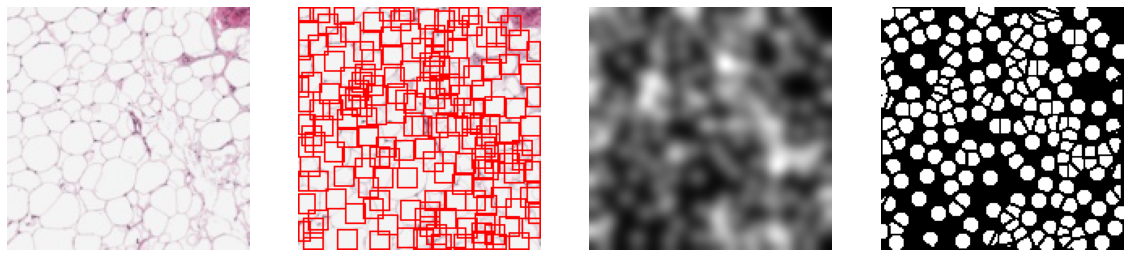

In [82]:
detection_kws = {'side': 12}
density_kws = {
    'mode': 'reflect',
    'k_size': 41,
    'sigma': 5
}
segmentation_kws = {
    'radius': 5,
    'radius_ignore': 6,
    'v_bal': 0.1, 
    'sigma_bal': 3,
    'sep_width': 1,     
    'sigma_sep': 3,
    'lambda_sep': 50
}

_ = show_samples_and_targets(
    root='data/adipocyte-cells',
    sample_idx=5,
    detection_kws=detection_kws,
    density_kws=density_kws,
    segmentation_kws=segmentation_kws,
    save_figures=True,
    save_figures_prefix='adi'
)

dataset_stats('data/adipocyte-cells')

# BCData

In [6]:
detection_kws = {'side': 30}
density_kws = {
    'mode': 'reflect',
    'k_size': 81,
    'sigma': 15
}
segmentation_kws = {
    'radius': 15,
    'radius_ignore': 18,
    'v_bal': 0.1, 
    'sigma_bal': 7,
    'sep_width': 2,     
    'sigma_sep': 8,
    'lambda_sep': 50
}

_ = show_samples_and_targets(
    root='data/bcd-cells/test',
    sample_idx=3,
    detection_kws=detection_kws,
    density_kws=density_kws,
    segmentation_kws=segmentation_kws,
    save_figures=True,
    save_figures_prefix='bcd'
)

dataset_stats('data/bcd-cells/train')
dataset_stats('data/bcd-cells/validation')
dataset_stats('data/bcd-cells/test')
dataset_stats([
    'data/bcd-cells/train',
    'data/bcd-cells/validation',
    'data/bcd-cells/test'
])


data/bcd-cells/train+data/bcd-cells/validation+data/bcd-cells/test: 1338 images (640, 640, 3) - 181074 cells - 135.33$\pm$67.63 cells/image


# MBM Dataset

data/mbm-cells: 44 images - 5553 cells - 126.20$\pm$33.13 cells/image


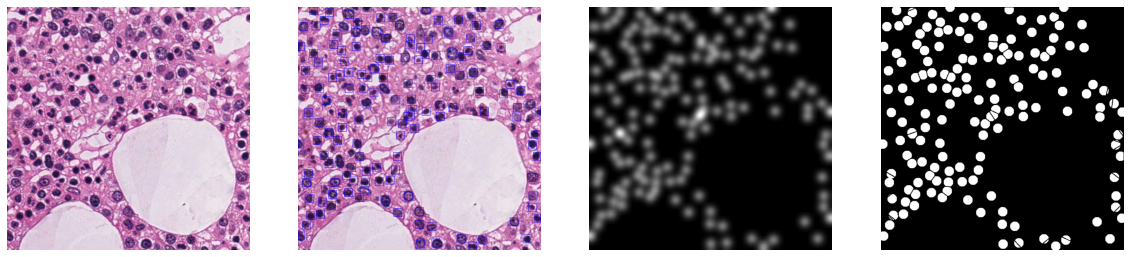

In [84]:

detection_kws = {'side': 20}
density_kws = {
    'mode': 'reflect',
    'k_size': 51,
    'sigma': 10
}
segmentation_kws = {
    'radius': 12,
    'radius_ignore': 15,
    'v_bal': 0.1, 
    'sigma_bal': 5,
    'sep_width': 1,     
    'sigma_sep': 4,
    'lambda_sep': 50
}

_ = show_samples_and_targets(
    root='data/mbm-cells',
    sample_idx=2,
    detection_kws=detection_kws,
    detection_boxes_color=(0, 0, 1),
    density_kws=density_kws,
    segmentation_kws=segmentation_kws,
    save_figures=True,
    save_figures_prefix='mbm'
)

dataset_stats('data/mbm-cells')

# VGG

data/vgg-cells: 200 images - 35192 cells - 175.96$\pm$61.24 cells/image


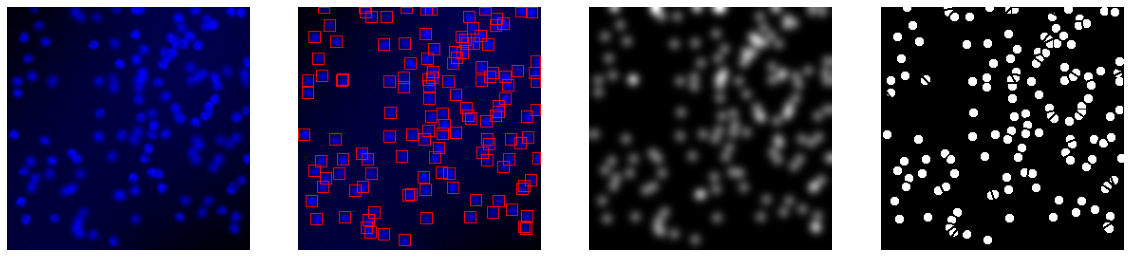

In [85]:
detection_kws = {'side': 12}
density_kws = {
    'mode': 'reflect',
    'k_size': 41,
    'sigma': 5
}
segmentation_kws = {
    'radius': 5,
    'radius_ignore': 6,
    'v_bal': 0.1, 
    'sigma_bal': 3,
    'sep_width': 1,     
    'sigma_sep': 3,
    'lambda_sep': 50
}

_ = show_samples_and_targets(
    root='data/vgg-cells',
    detection_kws=detection_kws,
    density_kws=density_kws,
    segmentation_kws=segmentation_kws,
    save_figures=True,
    save_figures_prefix='vgg'
)

dataset_stats('data/vgg-cells')

# PNN Dataset

## Examples

In [86]:
common = dict(split='train-half1', random_offset=0, patch_size=640)
detection_kws = {
    'target': 'detection',
    'target_params': {
        'side': 45
    }
}

density_kws = {
    'target': 'density',
    'target_params': {
        'mode': 'reflect',
        'k_size': 151,
        'sigma': 15
    }
}

segmentation_kws = {
    'target': 'segmentation',
    'target_params': {
        'radius': 20,
        'radius_ignore': 25,
        'v_bal': 0.1, 
        'sigma_bal': 10,
        'sep_width': 1,     
        'sigma_sep': 6,
        'lambda_sep': 50
    }
}

detection_dataset = PerineuronalNetsDataset(**detection_kws, **common)
density_dataset = PerineuronalNetsDataset(**density_kws, **common)
segmentation_dataset = PerineuronalNetsDataset(**segmentation_kws, **common)

In [103]:
random_samples = np.random.randint(0, len(detection_dataset), 10000)

cells_per_sample = [len(detection_dataset[x][0][1]) for x in tqdm(random_samples)]
best_samples = np.argsort(cells_per_sample)[::-1]

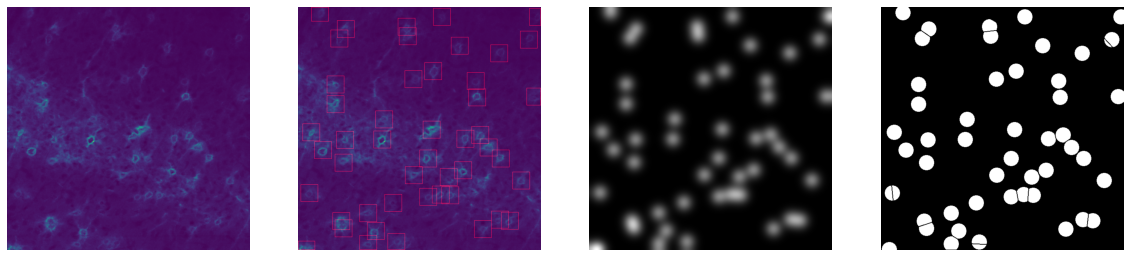

In [105]:
#sample_idx = random_samples[best_samples[31]]
sample_idx = random_samples[best_samples[12]]

sample = density_dataset[sample_idx][0][:, :, 0]
detections = detection_dataset[sample_idx][0][1]
density_map = density_dataset[sample_idx][0][:, :, 1]
segmentation_map = segmentation_dataset[sample_idx][0][:, :, 1]
weights_map = segmentation_dataset[sample_idx][0][:, :, 2]

detections = np.clip(detections.astype(int), 0, sample.shape[0] - 1)
sw_map = np.stack((segmentation_map, weights_map, np.zeros_like(sample)), axis=-1)

sample = matplotlib.cm.viridis(sample)
density_map = gray2rgb(density_map / density_map.max())
segmentation_map = gray2rgb(segmentation_map)

sample_with_boxes = sample.copy()
for y0, x0, y1, x1 in detections:
    rect = ((y0, x0, y0, x1),
            (y0, x1, y1, x1),
            (y1, x1, y1, x0),
            (y1, x0, y0, x0))
    for r0, c0, r1, c1 in rect:
        rr, cc, val = line_aa(r0, c0, r1, c1)
        sample_with_boxes[rr, cc, 0] = val

        
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
axes = axes.flatten()
axes[0].imshow(sample)
axes[1].imshow(sample_with_boxes)
axes[2].imshow(density_map)
axes[3].imshow(segmentation_map)

for ax in axes:
    ax.set_axis_off()

# plt.imsave('figures/pnn-sample.png', sample)
# plt.imsave('figures/pnn-boxes.png', sample_with_boxes)
# plt.imsave('figures/pnn-density.png', density_map)
# plt.imsave('figures/pnn-segmentation.png', segmentation_map)

## Groundtruth Properties

In [89]:
gt = pd.read_csv('data/perineuronal-nets/test/annotations.csv')
gt['agreement'] = gt.loc[:, 'AV':'VT'].sum(axis=1)

gt.groupby('imgName').X.count()

imgName
021_A1_s07_C1_crop.tif    207
026_A6_s02_C1_crop.tif    255
033_B3_s06_C1_crop.tif    220
051_B1_s03_C1_crop.tif    229
057_B3_s03_C1_crop.tif    198
061_A1_s08_C1_crop.tif    220
063_A3_s04_C1_crop.tif    174
068_B2_s03_C1_crop.tif    214
073_A5_s12_C1_crop.tif    195
075_B1_s04_C1_crop.tif    143
088_A4_s06_C1_crop.tif    205
092_B2_s05_C1_crop.tif     91
Name: X, dtype: int64

### Distribution of Agreement in the (Multi-Rater) Test Set

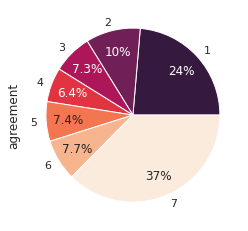

In [90]:
sns.set_theme(context='notebook', style='ticks')
data = gt.agreement.value_counts().sort_index()
_, _, autotexts = plt.pie(data.values, labels=data.index,
                          autopct='{:.2g}%'.format, pctdistance=0.75,
                          # colors=sns.color_palette('rocket', 7)
                          colors=sns.color_palette('rocket', as_cmap=True)(np.linspace(0, 1, 8)[1:])
                         )
plt.ylabel('agreement')

plt.setp(autotexts, size=12)
for t in autotexts[:4]:
    t.set_color('white')
    

In [99]:
pnn_cells = PerineuronalNetsRankDataset(mode='patches')

x = enumerate(pnn_cells.annot.agreement.values)
x = sorted(x, key=lambda x: x[1])
x = itertools.groupby(x, key=lambda x: x[1])

means = []
for agreement, group in x:
    samples = [i for i, _ in group]
    images = [pnn_cells[i][0][:, :, 0].astype(np.float32) / 255. for i in samples]
    mean = np.mean(images, axis=0)
    means.append(mean)
    
    sorted_samples = np.sum((images * mean), axis=(1,2)).argsort()
    sorted_samples = np.array(samples)[sorted_samples][::-1]
    
    print(f'{agreement}:', sorted_samples[:12].tolist(), ',')

pnn_means = np.stack(means)
pnn_means = (pnn_means - np.min(pnn_means)) / (np.max(pnn_means) - np.min(pnn_means))
pnn_means = matplotlib.cm.viridis(pnn_means)[:,:,:,:3]

1: [311, 287, 288, 982, 977, 976, 72, 975, 702, 397, 798, 1799] ,
2: [386, 391, 210, 1003, 825, 904, 356, 1826, 1722, 822, 826, 400] ,
3: [390, 393, 983, 1004, 1005, 984, 392, 1874, 872, 1717, 215, 358] ,
4: [959, 990, 999, 1001, 1000, 217, 928, 936, 1872, 931, 219, 421] ,
5: [220, 395, 385, 996, 994, 958, 991, 960, 987, 993, 927, 986] ,
6: [207, 388, 378, 428, 1761, 1439, 1436, 1866, 848, 820, 1153, 1487] ,
7: [387, 381, 383, 1878, 398, 399, 380, 382, 154, 384, 1868, 354] ,


Text(3.51, 1, 'samples')

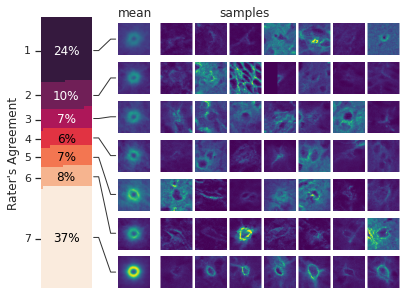

In [101]:
a = sorted(gt.agreement.values) + [100]
a = np.array(a).reshape((112, -1))

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(a, vmin=0, vmax=7, square=True,
            linewidths=0,
            antialiased=True,
            rasterized=True,
            cbar=False, cbar_kws={"orientation": "horizontal", 'pad': 0.05, 'ticks': range(0, 8), 'drawedges': True})
plt.xticks([])
plt.ylabel('Rater\'s Agreement')

def find_pos(a):
    pos = np.unique(a, return_counts=True)[1].cumsum()
    pos = np.insert(pos, 0, 1)
    pos = (pos[:-1] + pos[1:]) / 2
    return pos

l_pos = find_pos(a[:, 0])
r_pos = find_pos(a[:, 1])

_ = plt.yticks(l_pos, range(1, 8), rotation=0)

_, x_limit = plt.xlim()
y_limit, _ = plt.ylim()

def shuf(l):
    l = l[:]
    random.shuffle(l)
    return l

sample_indices = {    
    1: [1565, 2300, 1913, 311, 1799, 763, 72],
    2: [2309, 386, 983, 56, 286, 951, 1774],
    3: [198, 1874, 392, 872, 78, 390, 1103],
    4: [777, 219, 1944, 1066, 217, 1115, 96],
    5: [220, 2174, 945, 389, 385, 1633, 593],
    6: [2218, 2058, 1436, 2212, 2034, 1433, 207],
    7: [453, 7, 6, 4, 12, 644, 20]
}

pct = gt.agreement.value_counts()
pct = pct / pct.sum()
pct = pct.sort_index().values

cell_x = 1.51
nr = 1
for i, (ry, ly) in enumerate(zip(r_pos, l_pos), start=1):
    cell_y = 1 - (i / len(sample_indices))

    # percentage
    ax.annotate(f'{pct[i - 1]:.0%}', (0.5, 1 - (ry+ly) / (2*y_limit)), xycoords='axes fraction',
                color='white' if i < 4 else 'black', ha='center', va='center')
    
     # connector
    ax.annotate('', xy=(1, 1 - ry / y_limit), xycoords='axes fraction',
            xytext=(cell_x, cell_y + 0.06), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='-', color='0.2', connectionstyle='arc,angleA=0,angleB=0,armA=-7,armB=7,rad=0'))
    
    # mean image
    imagebox = OffsetImage(pnn_means[i - 1], zoom=0.5, origin='upper')
    ab = AnnotationBbox(imagebox, (cell_x, cell_y), xycoords='axes fraction', frameon=False, box_alignment=(0,0))
    ax.add_artist(ab)
    
    # samples
    cell_images = [pnn_cells[j][0][:, :, 0] for j in sample_indices[i]]
    cell_images = [matplotlib.cm.viridis(c) for c in cell_images]
    cell_images = np.stack(cell_images)[:,:,:,:3]
    image = montage(cell_images, grid_shape=(nr, len(cell_images) / nr), padding_width=5, fill=(1, 1, 1), multichannel=True)
    image = image[5:-5, ...]
    
    imagebox = OffsetImage(image, zoom=0.5, origin='upper')
    ab = AnnotationBbox(imagebox, (cell_x + 0.8, cell_y), xycoords='axes fraction', frameon=False, box_alignment=(0,0))
    ax.add_artist(ab)
    
ax.annotate('mean', (cell_x, 1), xycoords='axes fraction')
ax.annotate('samples', (cell_x + 2, 1), xycoords='axes fraction')
# plt.savefig('figures/pnn-mr-breakdown.pdf', bbox_inches='tight')

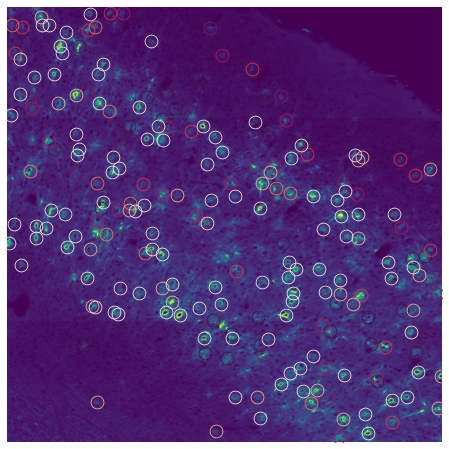

In [93]:
sample_id = gt.imgName.unique()[2]
img = plt.imread('data/perineuronal-nets/test/fullFrames/' + sample_id)
p2, p98 = np.percentile(img, (0.1, 99.9))
img = exposure.rescale_intensity(img, in_range=(p2, p98))
img = transform.resize(img, (1024, 1024))
img = matplotlib.cm.viridis(img)[:,:,:3]

scale_f = img.shape[0] / 2000

plt.figure(figsize=(8, 8))
plt.imshow(img)
ax = plt.gca()
ax.set_axis_off()

colors = sns.color_palette('rocket', as_cmap=True)(np.linspace(0, 1, 8)[1:])
for agreement, group in gt.set_index('imgName').loc[sample_id].groupby('agreement'):
    color = colors[agreement - 1]
    xs, ys = (group[['X', 'Y']].values * scale_f).astype(int).T
    ax.plot(xs, ys, 'o', ms=25*scale_f, mec=color, mfc='none', mew=0.8)

# plt.savefig('figures/pnn-mr-sample.pdf', bbox_inches='tight')

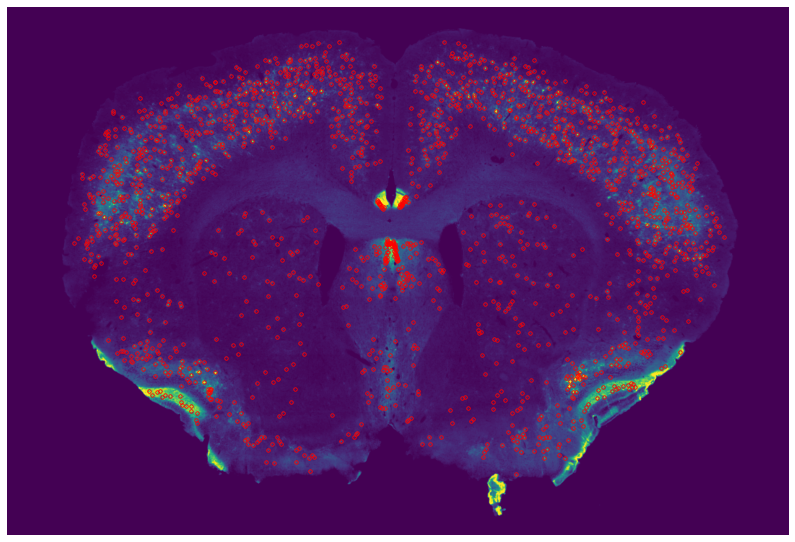

In [94]:
gt_sr = pd.read_csv('data/perineuronal-nets/train/annotations.csv')

sample_id = '034_B4_s06_C1.tif'
img = imread('data/perineuronal-nets/train/fullFrames/' + sample_id)

new_shape = (np.array(img.shape) / 10).astype(int)
scale_f = new_shape[0] / img.shape[0]

img = transform.resize(img, new_shape)

p2, p98 = np.percentile(img, (0.1, 99.9))
img = exposure.rescale_intensity(img, in_range=(p2, p98))

img = matplotlib.cm.viridis(img)[:,:,:3]

plt.figure(figsize=(14, 14))
plt.imshow(img)
ax = plt.gca()
ax.set_axis_off()

xy = gt_sr.set_index('imageName').loc[sample_id, ['X', 'Y']].values * scale_f
xs, ys = xy.astype(int).T
ax.plot(xs, ys, 'o', ms=35 * scale_f, mec='red', mfc='none', mew=0.8)

# plt.savefig('figures/pnn-sr-sample.pdf', bbox_inches='tight')

### Agreement between Raters in the Test Set

<AxesSubplot:>

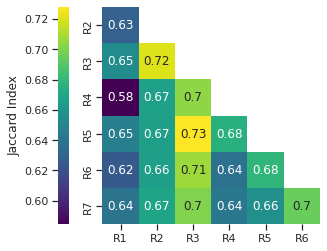

In [95]:
raters = gt.loc[0, 'AV':'VT'].index.values
raters = np.array(raters).reshape(-1, 1)

def agree(r1, r2):
    a, b = gt[r1], gt[r2]
    return jaccard_score(a, b)

raters_agreement = pdist(raters, agree)
raters_agreement = squareform(raters_agreement)

mask = 1 - np.tri(len(raters), k=-1)

raters_agreement = raters_agreement[1:, :-1]
mask = mask[1:, :-1]

ylabels = [f'R{i+2}' for i in range(len(raters)-1)]
xlabels = [f'R{i+1}' for i in range(len(raters)-1)]
sns.heatmap(raters_agreement, mask=mask, annot=True, square=True,
            xticklabels=xlabels, yticklabels=ylabels, cmap='viridis',
            cbar_kws=dict(location='left', label='Jaccard Index'))
# plt.savefig('figures/raters-agreement.pdf', bbox_inches='tight')

### Total Cells counted by each Rater

/tmp/ipykernel_118/539816099.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = counts.mean().item()


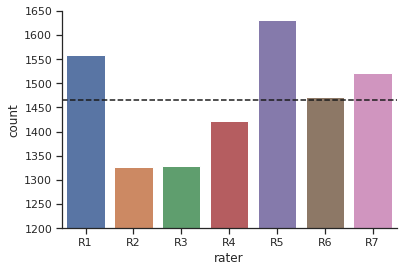

In [96]:
counts = gt.loc[:, 'AV':'VT'].sum(axis=0)
counts.index = [f'R{i+1}' for i in range(len(counts))]
counts = counts.to_frame(name='count')
counts = counts.reset_index().rename({'index': 'rater'}, axis=1)
ax = sns.barplot(data=counts, x='rater', y='count')

mean = counts.mean().item()
ax.axhline(mean, c='k', ls='--', lw=1.5)
ax.set_ylim(1200, 1650)
sns.despine()